In [1]:
from __future__ import division

from pylab import *
import scipy
import time

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [2]:
def ngram_encode(ngram_str, letter_vecs, alph, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1
    

In [3]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000000
D = len(alph)
n_steps = 500
letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1

In [4]:
def train(ngram_strs, encode):
    psi = np.zeros(N)
    for i in range(len(ngram_strs)):
        psi += encode(ngram_strs[i], letter_vecs, alph)
    return psi

def predict_coefs(n_steps, ngram_str, bound_vec):
    l_states = np.random.randn(len(ngram_str)+2, N)
    for i in range(1,l_states.shape[0]-1):
        l_states[i] = np.dot(letter_vecs.T, np.dot(l_states[i], letter_vecs.T))
        l_states[i] = l_states[i]/norm(l_states[i])

    l_states[0] = letter_vecs[alph.find('#'), :]
    l_states[l_states.shape[0]-1] = letter_vecs[alph.find('.'), :]

    l_coef_hists = np.zeros((n_steps, l_states.shape[0], D))
    for i in range(n_steps):
        for j in range(1,l_states.shape[0]-1):
            l_coef_hists[i, j, :] = np.dot(letter_vecs, l_states[j])

            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            mxjidx = np.argmax(np.abs(l_coef_hists[i, j, :]))
            l_states[j] *= np.sign(l_coef_hists[i, j, mxjidx])
            if j == 1:
                ljd = (np.roll(bound_vec * l_states[j-1] * np.roll(l_states[j+1], 2), -1) +
                  bound_vec * np.roll(l_states[j+1], 1) * np.roll(l_states[j+2], 2))
            elif 1 < j < l_states.shape[0]-2:
                ljd = (np.roll(bound_vec * l_states[j-2] * np.roll(l_states[j-1], 1), -2) +
                    np.roll(bound_vec * l_states[j-1] * np.roll(l_states[j+1], 2), -1) +
                        bound_vec * np.roll(l_states[j+1], 1) * np.roll(l_states[j+2], 2))
            else:
                ljd = (np.roll(bound_vec * l_states[j-1] * np.roll(l_states[j+1], 2), -1) +
                       np.roll(bound_vec * l_states[j-2] * np.roll(l_states[j-1], 1), -2))

            l_states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T))
            l_states[j] = l_states[j]/norm(l_states[j])
    return l_states, l_coef_hists

def graph(n_steps, l_coef_hists):
    figure(figsize=(10,3))
    cols = get_cmap('copper', n_steps)
    for i in range(n_steps):
        for j in range(1,l_coef_hists.shape[1]-1):
            subplot(130+j)
            plot(abs(l_coef_hists[i,j,:]), lw=3, c=cols(i))
    
def predict(l_coef_hists):
    prediction = ""
    for i in range(1,l_coef_hists.shape[1]-1):
        prediction += alph[np.argmax(abs(l_coef_hists[-1,i,:]))]
    print prediction

In [7]:
# testing noise tolerance
# does this mean that bound vec specific to a word 
# has the same dot product for every correct pair????
#ngram_str = 'banana'#'the'
ngram_str = 'the'
train_set = ['the', 'fam', 'sailboat', 'nuclear', 'compulsive', 'whatisthis']
ngram_vecs = [ngram_encode_cl(verb, letter_vecs, alph) for verb in train_set]
psi = train(train_set, ngram_encode)
similarities = np.zeros(len(train_set)**2)

#figure()
for i in range(len(ngram_vecs)):
    bound_vec = psi*ngram_vecs[i]
    bound_vec = 2* (bound_vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1
    print bound_vec
    for j in range(len(ngram_vecs)):
        #if i == j:
        similarities[i+j] = bound_vec.dot(ngram_vecs[j])
        print (train_set[i], train_set[j], similarities[i+j])
#plot(similarities)

[-1  1 -1 ..., -1 -1  1]
('the', 'the', -1762.0)
('the', 'fam', 1474.0)
('the', 'sailboat', 1426.0)
('the', 'nuclear', -1100.0)
('the', 'compulsive', 416.0)
('the', 'whatisthis', -440.0)
[ 1 -1 -1 ...,  1 -1  1]
('fam', 'the', 1474.0)
('fam', 'fam', -1762.0)
('fam', 'sailboat', -302.0)
('fam', 'nuclear', -368.0)
('fam', 'compulsive', -524.0)
('fam', 'whatisthis', 272.0)
[1 1 1 ..., 1 1 1]
('sailboat', 'the', 1426.0)
('sailboat', 'fam', -302.0)
('sailboat', 'sailboat', -1762.0)
('sailboat', 'nuclear', -92.0)
('sailboat', 'compulsive', 128.0)
('sailboat', 'whatisthis', -788.0)
[-1 -1  1 ...,  1  1  1]
('nuclear', 'the', -1100.0)
('nuclear', 'fam', -368.0)
('nuclear', 'sailboat', -92.0)
('nuclear', 'nuclear', -1762.0)
('nuclear', 'compulsive', 202.0)
('nuclear', 'whatisthis', -1238.0)
[1 1 1 ..., 1 1 1]
('compulsive', 'the', 416.0)
('compulsive', 'fam', -524.0)
('compulsive', 'sailboat', 128.0)
('compulsive', 'nuclear', 202.0)
('compulsive', 'compulsive', -1762.0)
('compulsive', 'whatisth

In [ ]:
#ngram_str = 'banana'#'the'
ngram_str = 'the'
psi = train(['the', 'fam'], ngram_encode)
bound_vec = psi*ngram_encode(ngram_str, letter_vecs, alph)
l_states, l_coef_hists = predict_coefs(500, ngram_str, bound_vec)
graph(500, l_coef_hists)
predict(l_coef_hists)

the


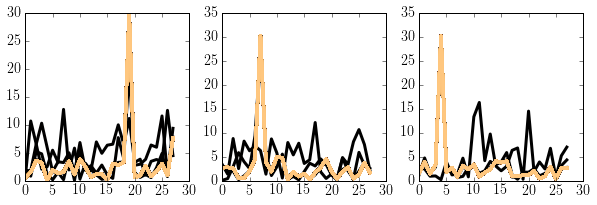

In [32]:
#ngram_str = 'banana'#'the'
ngram_str = 'the'
psi = train(['the'], ngram_encode)
bound_vec = psi
l_states, l_coef_hists = predict_coefs(n_steps, ngram_str, bound_vec)
graph(n_steps, l_coef_hists)
predict(l_coef_hists)